# ISLR- Python Ch7 Applied 5

- [Import College Data](#Import-College-Data)
- [Split Data](#Split-Data)
- [Perform Forwards Step Selection](#Perform-Forward-Step-Selection)
- [Fit a GAM](#Fit-a-GAM)
- [Evaluate Model](#Evaluate-Model)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrix
from collections import defaultdict
from operator import itemgetter
from pandas import scatter_matrix 

%matplotlib inline
plt.style.use('ggplot')

## Import College Data

In [11]:
college = pd.read_csv('../../../data/College.csv', index_col=0)
college.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, Abilene Christian University to York College of Pennsylvania
Data columns (total 18 columns):
Private        777 non-null object
Apps           777 non-null int64
Accept         777 non-null int64
Enroll         777 non-null int64
Top10perc      777 non-null int64
Top25perc      777 non-null int64
F.Undergrad    777 non-null int64
P.Undergrad    777 non-null int64
Outstate       777 non-null int64
Room.Board     777 non-null int64
Books          777 non-null int64
Personal       777 non-null int64
PhD            777 non-null int64
Terminal       777 non-null int64
S.F.Ratio      777 non-null float64
perc.alumni    777 non-null int64
Expend         777 non-null int64
Grad.Rate      777 non-null int64
dtypes: float64(1), int64(16), object(1)
memory usage: 115.3+ KB


In [12]:
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [13]:
# Private is a categorical so we convert it to a dummy vaiable
college = pd.get_dummies(data=college, columns=['Private'])

In [49]:
college.head(1)

,Apps,Accept,Enroll,Top10perc,Top25perc,FUndergrad,PUndergrad,Outstate,Board,Books,Personal,PhD,Terminal,SFRatio,pAlumni,Expend,GradRate,Private_Yes
Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1.0


In [15]:
del college['Private_No']
#rename some of the columns so they don't have annoying dots
college.rename(columns={'F.Undergrad': 'FUndergrad', 'P.Undergrad': 'PUndergrad', 'Room.Board':'Board', 
                       'S.F.Ratio':'SFRatio', 'perc.alumni':'pAlumni', 'Grad.Rate':'GradRate'}, inplace=True)

## Split Data

In [43]:
np.random.seed(0)
train = np.random.choice([True, False], len(college))
college_train = college.iloc[train]
college_test = college.iloc[~train]

## Perform Forwards Step Selection

In Chapter 6 we wrote functions to perform the forward-step-selection algorithm. The function is copied below. It requires statsmodels to run.

In [26]:
def forward_step_select(df, predictors, response, max_features=17):
    """
    Regresses response onto predictors using a forward step algorithm. Features are added based on minimum RSS.
    
    PARAMETERS
    -----------
    df : dataframe containing predictors and responses
    predictors : list of all possible model predictors
    response : list[variable] to regress onto predictors in df
    max_features : maximum number of features to use from predictors list
    
    RETURNS
    --------
    list of models with increasing number of features upto max_features
    
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(df[features])
        y = df[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def update_model(best_features, remaining_features):
        """
        Computes the RSS of possible new models and returns the model with the lowest RSS.
        """
        results = []
        
        for feature in remaining_features:
            results.append(process_linear_model(best_features + [feature]))
            
        # select model with the lowest RSS
        new_model = sorted(results, key= itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    # Create list to hold models, model features and the remaining features to test
    models = []
    best_features = []
    remaining_features = predictors
    
    while remaining_features and len(best_features) < max_features:
        
        # get the best new feature set from update_model
        new_features, new_model = update_model(best_features, remaining_features)
        # update the best features to include the one we just found
        best_features = new_features  
        # reduce the available features for the next round
        remaining_features =  [feature for feature in predictors if feature not in best_features]
        
        # append the new_features and model so we can compare models with different features later
        models.append((new_features,new_model))
        
    return models

In [27]:
predictors = list(college.columns)
predictors.remove('Outstate')
models = forward_step_select(df=college_train, predictors=predictors, response=['Outstate'],max_features=17 )

In [28]:
# Best 8 feature model for example.
models[7][1].params

const         -2102.293200
Expend            0.179367
pAlumni          53.396641
Board             0.818183
Private_Yes    2343.221720
PhD              19.442991
GradRate         31.131594
SFRatio         -88.616070
Terminal         26.544411
dtype: float64

Now we need to evaluate which of the models is best. We can't use the RSS here because the RSS decreases as the number of features increases. Instead we will use Infromation Criteria and the adjusted R^2.

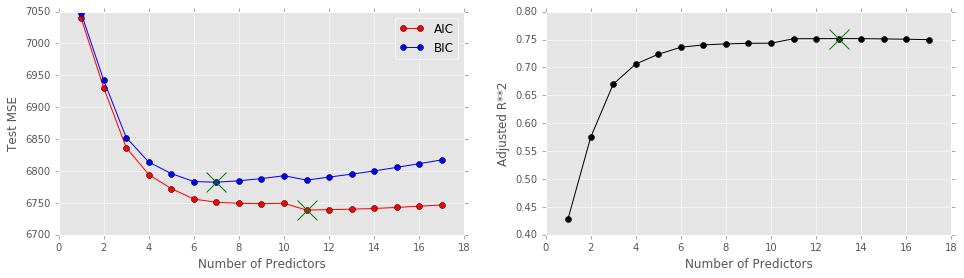

In [29]:
# Three metrics to evaluate the best model AIC, BIC and adj, R^2
aics = [models[x][1].aic for x in range(len(models))]
bics = [models[x][1].bic for x in range(len(models))]
r_adj = [models[x][1].rsquared_adj for x in range(len(models))]

# find the mins/maxes
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(models),len(models))
# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
# Add test MSE estimates
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

So the metrics each pick a slightly different model. An 8 predictor model seems best since that model is around the bend in most of the metric plots.

## Fit a GAM

Before we fit a GAM for the best predictors, we want to look at the data to see if there is any evidence that for the best predictors there is a non-linear relationship with the response 'Outstate'.

In [41]:
# Here is the best 8 feature model
best_predictors = list(models[7][1].params.index[1:])
print(best_predictors)

['Expend', 'pAlumni', 'Board', 'Private_Yes', 'PhD', 'GradRate', 'SFRatio', 'Terminal']


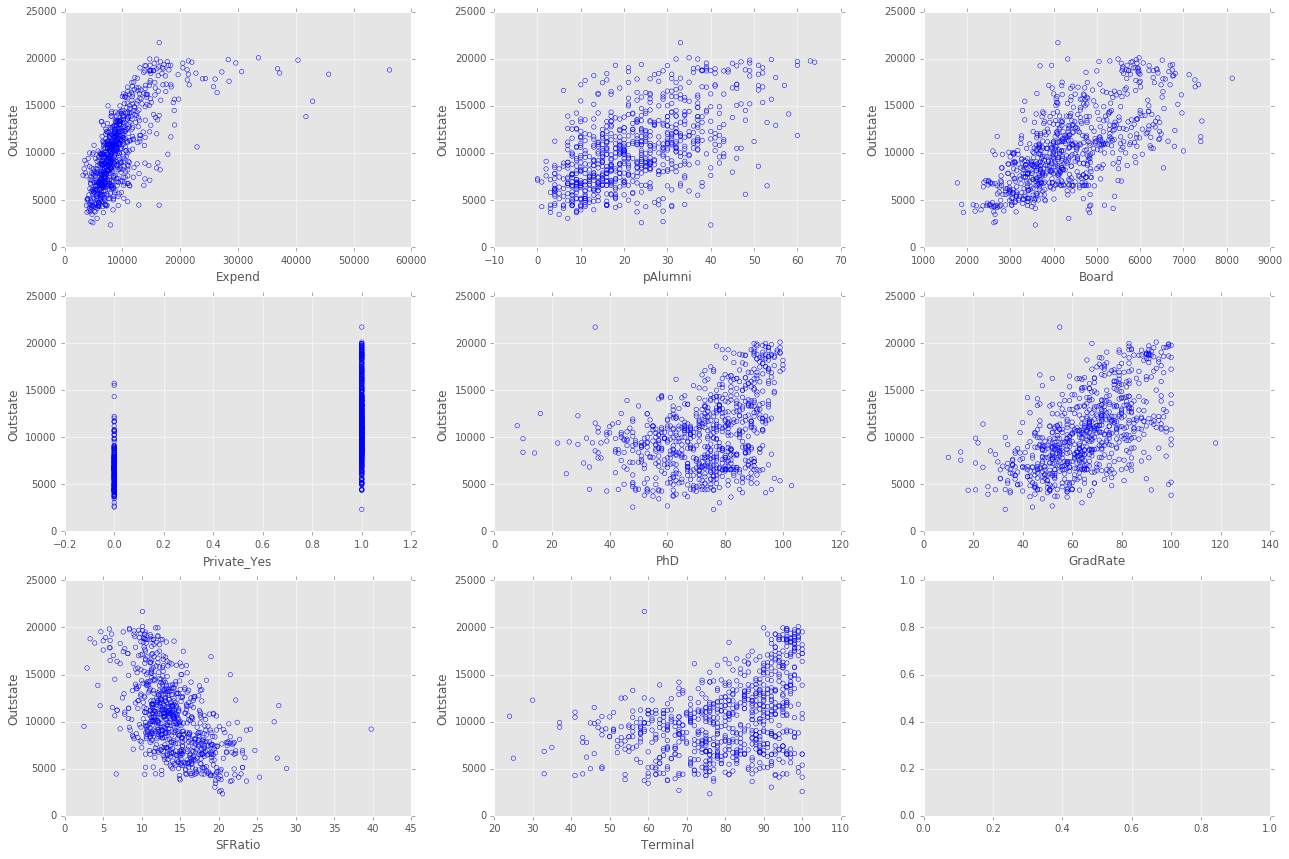

In [31]:
# Plot the data to look for any conspicuous non-linearities
# Boxplots of the categoricals
fig, axarr = plt.subplots(3,3,figsize = (18,12))
for el, predictor in enumerate(best_predictors):
    index = np.unravel_index(el,(3,3))
    axarr[index[0], index[1]].scatter(college[predictor],college.Outstate, facecolor='none', edgecolor='b');
    axarr[index[0], index[1]].set_xlabel(predictor);
    axarr[index[0], index[1]].set_ylabel('Outstate');
    plt.tight_layout()
plt.suptitle('');

It is a little hard to tell whether there are any striking non-linearities in the college data. The expenditure and the Phd predictors do seem to have a little nonlinear relationship to the response. Lets build a GAM and see how stong this is.

In [37]:
# Build a design matix using Patsy #
####################################
# remember a GAM is just one large linear regression onto basis functions in the case that the smoothing 
# functions are natural splines.
design = dmatrix("1+cr(Expend, df=5, constraints='center') + pAlumni + Board + Private_Yes +\
                 cr(PhD, df=5, constraints='center') + GradRate + SFRatio + \
                 cr(Terminal, df=5, constraints='center')",
                 data={"Expend":college_train.Expend, 
                       "pAlumni": college_train['pAlumni'],
                       "Board":college_train['Board'], 
                       "Private_Yes":college_train.Private_Yes,
                       "PhD":college_train.PhD, 
                       "GradRate":college_train['GradRate'], 
                       "SFRatio":college_train.SFRatio,
                       "Terminal":college_train.Terminal},
                 return_type="dataframe")

# Fit Statsmodels OLS #
########################
# Again a GAM is just one large linear regression onto splines basis funcs so just construct an OLS model.
gam = sm.OLS(endog=college_train.Outstate, exog=design).fit()
print(gam.summary())

                            OLS Regression Results                            
Dep. Variable:               Outstate   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     64.33
Date:                Wed, 07 Dec 2016   Prob (F-statistic):          1.28e-104
Time:                        12:56:50   Log-Likelihood:                -3336.0
No. Observations:                 374   AIC:                             6714.
Df Residuals:                     353   BIC:                             6796.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------

In Ch7 Applied 2, I wrote a function to plot the basis functions similar to R's GAM plotting routine. Below is that function.

In [38]:
def gam_plot(data, design, gam_model, predictors):
    """
    A method to plot fitted basis functions similar to R's gam library and associated plot method.
    
    Parameters:
        data:       Original DataFrame containing all features.
        design:     An n_samples by n_features design dataframe with basis functions created using Patsy.
        gam_model:  A statsmodel fitted OLS object. 
        predictors: A list of string names for each of the predictors used to construct the gam.
        
        TO DO: Add SE bars
    """
    basis_funcs = defaultdict(np.array,[])
    extremums = defaultdict(list)
    
    # Compute the product of the design df with the coeffecients
    results = design * gam.params
    # find the columns that have the predictor in the col name and get the results from these columns
    for predictor in predictors:
        column_names = [col for col in design.columns if predictor in col]
        basis_funcs[predictor] = results[column_names]
        
        
    # Plotting
    num_rows = len(predictors)//3 + 1 if len(predictors)%3!=0 else len(predictors)//3
    fig, axarr = plt.subplots(num_rows, 3, figsize=(12,8))
    
    for el, predictor in enumerate(predictors):
        # get the tuple index to plot to
        plt_index = np.unravel_index(el,(num_rows, 3))
        
        # numeric predictors
        if data[predictor].values.dtype.type is np.int64:
            # get the order of the predictor and make a grid
            order = np.argsort(data[predictor])
            predictor_grid = data[predictor].values[order]
            # sum the basis functions and order the same as the predictor
            basis_vals = np.sum(basis_funcs[predictor].values, axis=1)[order]
            axarr[plt_index[0], plt_index[1]].plot(predictor_grid, basis_vals)
            
        else:
            # categorical predictors
            # make a temporary data frame
            s = pd.DataFrame(data[predictor])
            # add the sum of the basis functions for this categorical predictor
            s['f-'+predictor] = np.sum(basis_funcs[predictor].values, axis=1)
            # zero-mean
            s['f-'+predictor] = s['f-'+predictor] - s['f-'+predictor].mean()
            # call boxplot grouping by predictor col
            s.boxplot(column=['f-'+predictor], by=predictor, ax = axarr[plt_index[0], plt_index[1]]);
            axarr[plt_index[0], plt_index[1]].set_ylabel('F%d(%s)' %(el,predictor));
            plt.suptitle('')
            
        # Add Labels
        axarr[plt_index[0], plt_index[1]].set_xlabel(predictor);
        axarr[plt_index[0], plt_index[1]].set_ylabel('F%d(%s)' % (el,predictor));
        plt.tight_layout() 
                
    return basis_funcs

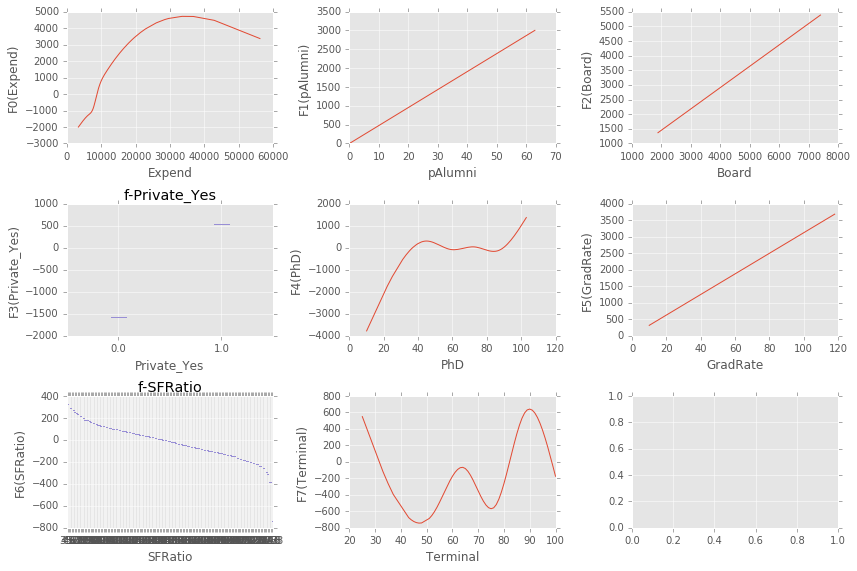

In [39]:
# be careful we renamed some of the predictors to get them into the formula
basis_funcs = gam_plot(data=college_train, design=design, gam_model=gam, predictors=best_predictors)

## Evaluate Model

So far we have only looked at the training data. Now we will evaluate the model on the held out test data.

In [48]:
# get the predicted values from the gam model on the test set
design = dmatrix("1+cr(Expend, df=5, constraints='center') + pAlumni + Board + Private_Yes +\
                 cr(PhD, df=5, constraints='center') + GradRate + SFRatio + \
                 cr(Terminal, df=5, constraints='center')",
                 data={"Expend":college_test.Expend, 
                       "pAlumni": college_test['pAlumni'],
                       "Board":college_test['Board'], 
                       "Private_Yes":college_test.Private_Yes,
                       "PhD":college_test.PhD, 
                       "GradRate":college_test['GradRate'], 
                       "SFRatio":college_test.SFRatio,
                       "Terminal":college_test.Terminal},
                 return_type="dataframe")
y_pred = gam.predict(design)

# compute the MSE of the model on the test set
gam_mse = np.mean((y_pred-college_test.Outstate)**2)
print(gam_mse)

3795949.79539


The GAM model does indicate some non-linearity in between the predictors and the response. It is necessary to get the SE bars in the GAM plot because we need to see how variable the fits are. 